<a href="https://colab.research.google.com/github/samuelhtampubolon/SDPM2025/blob/main/Klasifikasi_Breast_Cancer_Stratified_CV_ROC_PR_Confusion_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Validasi & Evaluasi klasifikasi biner
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, roc_curve, average_precision_score,
                             precision_recall_curve, confusion_matrix, classification_report)

#  Data & seed
seed = 2025
print("Random seed:", seed)
X, y = load_breast_cancer(return_X_y=True)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, stratify=y, random_state=seed)

Random seed: 2025


In [2]:
#  Pipeline & Stratified 5-fold CV (F1)
pipe = Pipeline([("scaler", StandardScaler()),
                 ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", solver="lbfgs"))])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cv_f1 = cross_val_score(pipe, X_tr, y_tr, cv=cv, scoring="f1")
print(f"CV F1: mean={cv_f1.mean():.3f} ± {cv_f1.std():.3f}")

CV F1: mean=0.979 ± 0.007


In [3]:
#  Train di full train; metrik probabilistik
pipe.fit(X_tr, y_tr)
proba = pipe.predict_proba(X_te)[:, 1]
auc = roc_auc_score(y_te, proba)
ap  = average_precision_score(y_te, proba)
print(f"Test ROC AUC: {auc:.3f}")
print(f"Test PR AUC (AP): {ap:.3f}")

Test ROC AUC: 0.985
Test PR AUC (AP): 0.990


In [4]:
#  Threshold optimal (F1)
prec, rec, thr = precision_recall_curve(y_te, proba)
f1 = 2*prec*rec/(prec+rec+1e-12)
best_idx = int(np.argmax(f1[:-1]))
best_thr = float(thr[best_idx])
y_hat = (proba >= best_thr).astype(int)
cm = confusion_matrix(y_te, y_hat)
print(f"Best F1={f1[best_idx]:.3f} @ thr={best_thr:.3f}")
print("Confusion matrix @best_thr:\n", cm)
print("Classification report @best_thr:\n", classification_report(y_te, y_hat, digits=3))

Best F1=0.973 @ thr=0.688
Confusion matrix @best_thr:
 [[49  4]
 [ 1 89]]
Classification report @best_thr:
               precision    recall  f1-score   support

           0      0.980     0.925     0.951        53
           1      0.957     0.989     0.973        90

    accuracy                          0.965       143
   macro avg      0.968     0.957     0.962       143
weighted avg      0.966     0.965     0.965       143



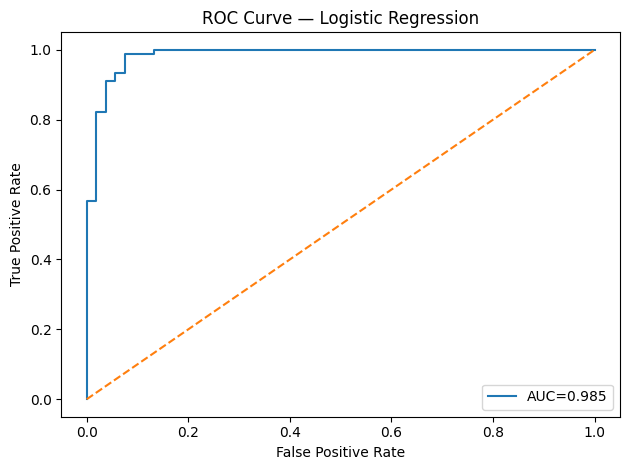

In [5]:
#  Grafik A - ROC Curve
fpr, tpr, _ = roc_curve(y_te, proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(); plt.tight_layout(); plt.show()

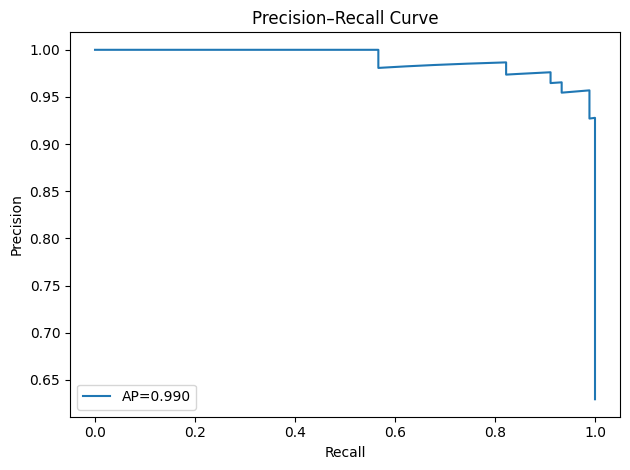

In [6]:
#  Grafik B - Precision–Recall Curve
plt.figure()
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(); plt.tight_layout(); plt.show()

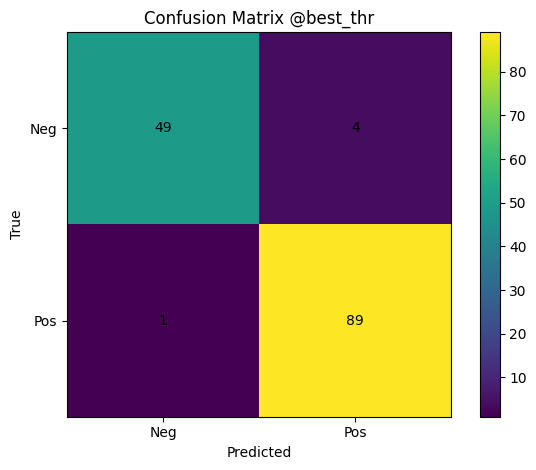

In [7]:
#  Grafik C - Confusion Matrix Heatmap
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix @best_thr"); plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ["Neg","Pos"]); plt.yticks(ticks, ["Neg","Pos"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()